In [1]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'replication_rate',
        root = '..'
    )

In [2]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from lapa.result import LapaResult

In [3]:
df_thresholds = list()

for lapa_dir in tqdm(snakemake.input['lapa_dir']):
    library_prep, platform, _ = Path(lapa_dir).name.split('_')
    
    if library_prep == 'quantseq':
        library_prep = 'Quantseq'

    lapa = LapaResult(lapa_dir)
    
    df_thresholds.append({
        'Data Source': f'{library_prep} {platform}',
        'threshold': lapa.read_clusters()['count'].min()
    })
    
df_thresholds = pd.DataFrame(df_thresholds)

  0%|          | 0/7 [00:00<?, ?it/s]

In [4]:
df_thresholds

,Data Source,threshold
0,cDNA PacBio,6
1,CapTrap PacBio,5
2,cDNA ONT,9
3,CapTrap ONT,5
4,R2C2 ONT,6
5,dRNA ONT,6
6,Quantseq Illumina,12


In [5]:
df_thresholds.to_csv(snakemake.output['table'], index=False)

  0%|          | 0/7 [00:00<?, ?it/s]

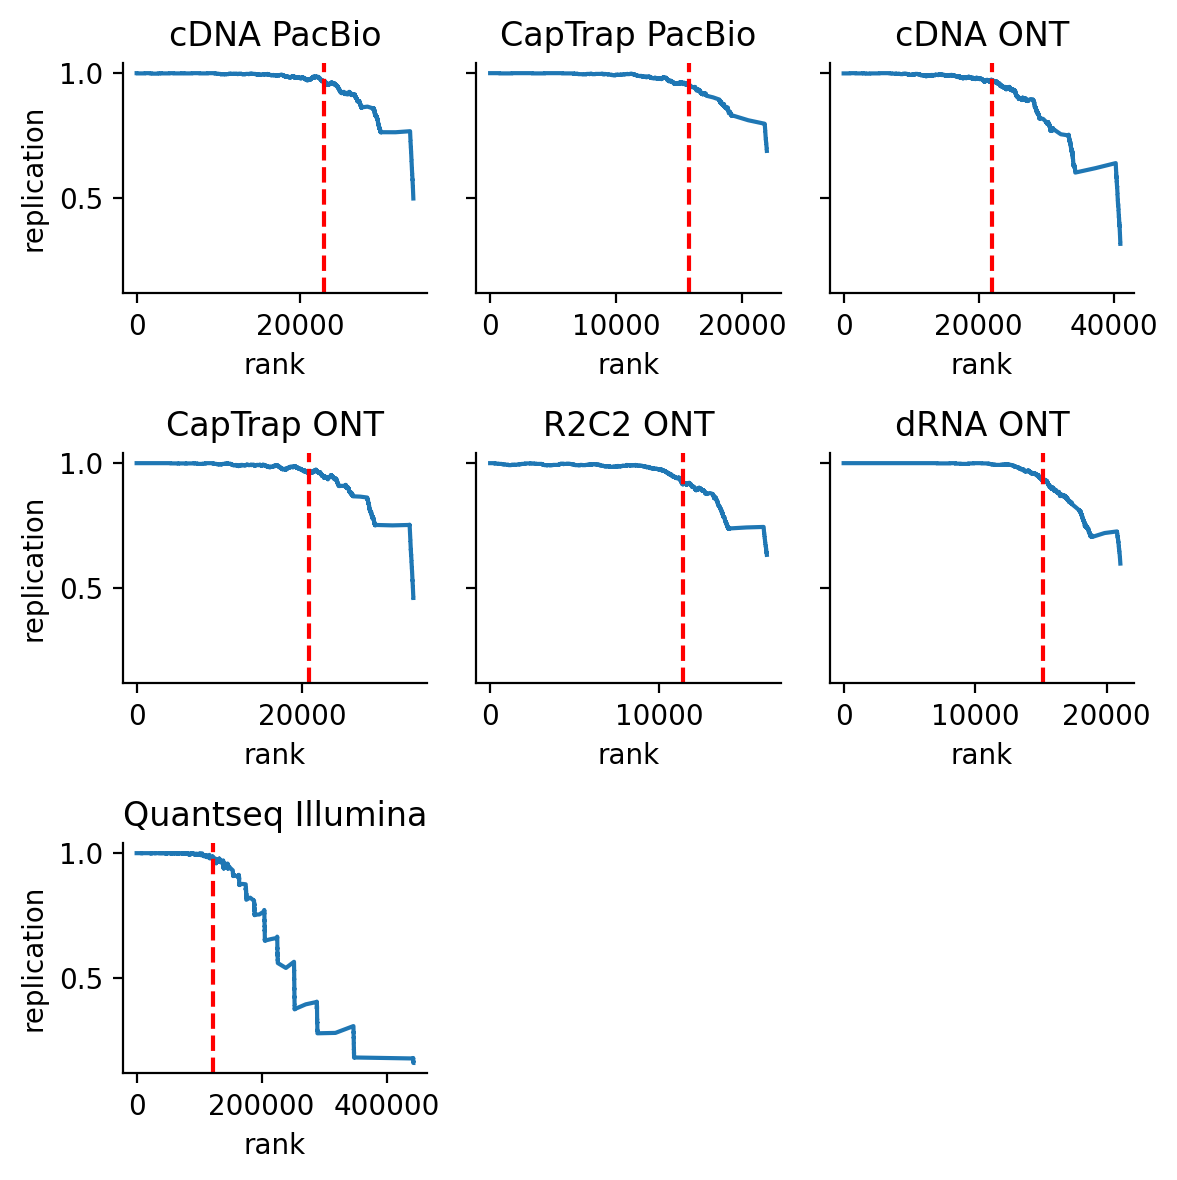

In [6]:
from more_itertools import flatten

_core_cols = ['Chromosome', 'Start', 'End', 'Strand']

n = 0

fig, axs = plt.subplots(3, 3, dpi=200, figsize=(6, 6), sharey=True, sharex=False)
axs = list(flatten(axs))

for ax in axs:
    ax.set_axis_off()

for lapa_dir in tqdm(snakemake.input['lapa_dir']):

    lapa = LapaResult(lapa_dir, replicated=False)
    library_prep, platform, _ = Path(lapa_dir).name.split('_')

    if library_prep == 'quantseq':
        library_prep = 'Quantseq'
    
    lapa.plot_replication_rate(line_kws={'ax': axs[n]})
    num_replicated = LapaResult(lapa_dir).read_clusters().drop_duplicates(_core_cols).shape[0]

    axs[n].axvline(x=num_replicated, c='r', linestyle='--')
    axs[n].set_title(f'{library_prep} {platform}')
    axs[n].set_axis_on()
    plt.locator_params(axis='both', nbins=3)
    
    n += 1

fig.tight_layout()
sns.despine()

plt.savefig(snakemake.output['fig'], bbox_inches = "tight")